In [14]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


#from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from darts                             import TimeSeries, concatenate
from darts.models                      import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr



from pytorch_lightning.callbacks   import EarlyStopping
from darts.utils.likelihood_models import QuantileRegression
from torch.optim.lr_scheduler      import ReduceLROnPlateau
from torch.optim                   import Adam

from sklearn.metrics import mean_squared_error


In [15]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [16]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["y"] = (pdf["Value_NE5"].values + pdf["Value_NE7"].values)/1e6 #in GWh
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

split = len(pdf)-365
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_12620\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,y
Timestamp,
2015-01-01,6.709087
2015-01-02,7.073348
2015-01-03,7.149544
2015-01-04,6.724467
2015-01-05,8.585045
...,...
2023-06-30,7.247760
2023-07-01,6.168368
2023-07-02,5.750607


In [17]:
ytrain = TimeSeries.from_dataframe(pdf_train)
ytest  = TimeSeries.from_dataframe(pdf_test)
ytotal = TimeSeries.from_dataframe(pdf)
ytotal


<TimeSeries (DataArray) (Timestamp: 3107, component: 1, sample: 1)>
array([[[6.70908714]],

       [[7.07334784]],

       [[7.14954415]],

       ...,

       [[5.75060674]],

       [[7.02940656]],

       [[6.82616489]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2015-01-01 2015-01-02 ... 2023-07-04
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Text(0.5, 1.0, 'one multivariate time series of 2 dimensions, containing covariates')

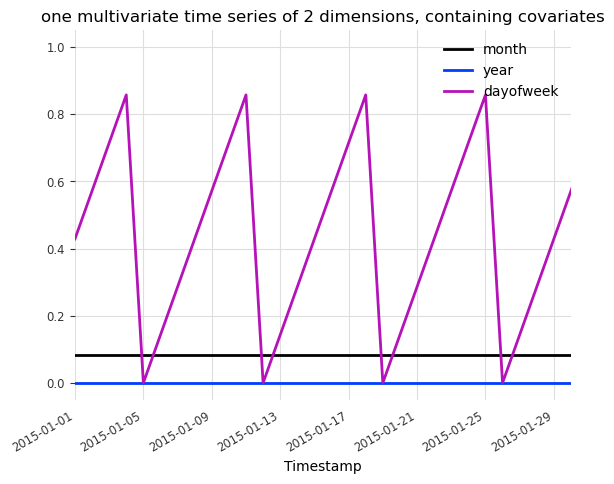

In [18]:
#create covariates from total time series
covs = concatenate( [dt_attr(ytotal.time_index, "month", dtype=np.float32) / 12,
                    (dt_attr(ytotal.time_index, "year", dtype=np.float32) - 2015) / 12,
                    (dt_attr(ytotal.time_index, "dayofweek", dtype=np.float32)) / 7],
                    axis="component")


covs.plot()
#set limit of the plot to the frist week in 2015
plt.xlim(pd.Timestamp("2015-01-01"), pd.Timestamp("2015-01-30"))
plt.title("one multivariate time series of 2 dimensions, containing covariates")

In [19]:
#NBEATSModel supports only past_covariates. Even though our covariates represent calendar information and are known in advance, 
#we will use them as past_covariates with N-BEATS. To train, all we have to do is give them as past_covariates to the fit() function, in the same order as the targets. 


model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,

)

model.fit(series=ytrain,
          past_covariates=covs,
          epochs=50, 
          verbose=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12)

In [20]:
y_pred = model.predict(n=len(ytest), 
                       series=ytrain,
                       past_covariates=covs
                       ).pd_series()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

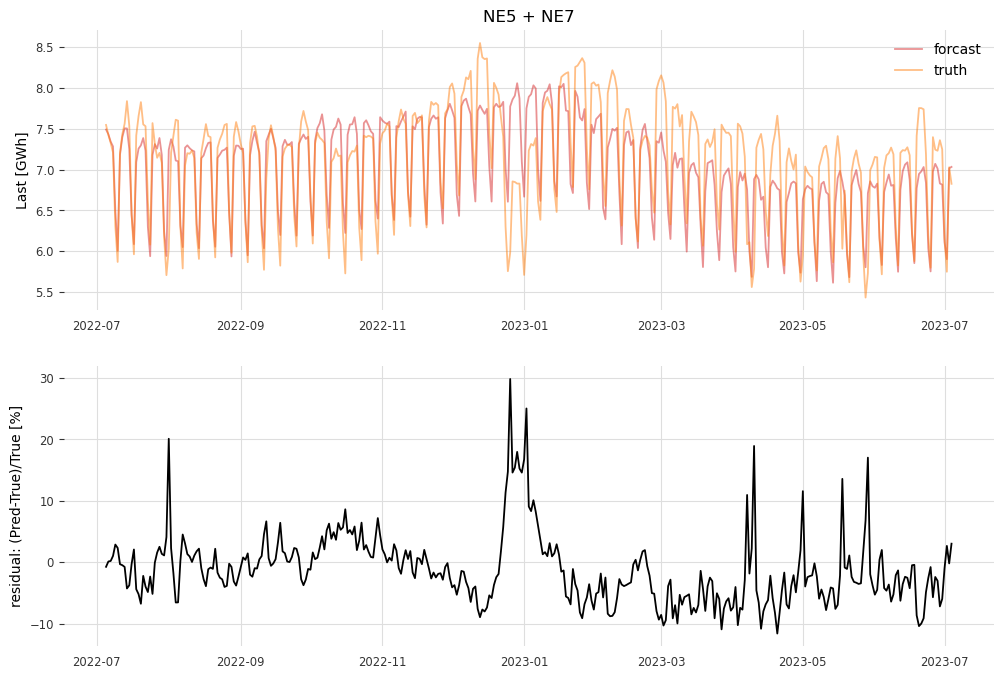

In [21]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(y_pred, color="tab:red", label="forcast", alpha=0.5)
# axes[0].plot(pdf_train[-2*365:], color="tab:blue", label="train")
axes[0].plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values) / (pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()


In [22]:
rmseValue = mean_squared_error(pdf_test.y.values, y_pred.values, squared=False)
rmseValue

0.404515861906048